Setting env variables

In [ ]:
import os
import demoSettings

os.environ["FHIR_BASE_URL"] = demoSettings.FHIR_BASE_URL
os.environ["FHIR_USERNAME"] = demoSettings.FHIR_USERNAME
os.environ["FHIR_PASSWORD"] = demoSettings.FHIR_PASSWORD

In [ ]:
import requests
import pandas as pd
import importlib
        
from pydantic import ConfigDict

base_url = os.environ["FHIR_BASE_URL"]
username = os.environ["FHIR_USERNAME"]
password = os.environ["FHIR_PASSWORD"]

# Load resource IDs from mappings_2.csv
mappings_df = pd.read_csv("../mappings_2.csv")

filtered_df = mappings_df[mappings_df["resource_type"].isin(["Encounter", "Condition"])]
filtered_versions = [
    (row["resource_id"], row["resource_type"], row["version_id"])
    for _, row in filtered_df.iterrows()
]

from collections import Counter
model_class_cache = {}

def get_fhir_model(resource_type):
    """Dynamically import and return the FHIR resource model class, with caching."""
    if resource_type.lower() in model_class_cache:
        return model_class_cache[resource_type.lower()]
    module_name = f"fhir.resources.{resource_type.lower()}"
    class_name = resource_type.capitalize()
    module = importlib.import_module(module_name)
    base_class = getattr(module, class_name)
    # Have to override classes to allow 'extra' fields as defined by pydantic
    class CustomModel(base_class):
        model_config = ConfigDict(extra='allow')
    model_class_cache[resource_type.lower()] = CustomModel
    return CustomModel

## There are some issues with the pydantic validator and fhir.resources.encounter.Encounter class. 
## Removing the Encounter.class and Encounter.participant.individual elements seems to resolve the issue for my Synthea dataset.
def preprocess_encounter_json(enc_json):
    # Remove 'class' field entirely if present
    if "class" in enc_json:
        del enc_json["class"]
    # Remove 'individual' field from each participant if present
    if "participant" in enc_json:
        for part in enc_json["participant"]:
            if "individual" in part:
                del part["individual"]
    return enc_json

condition_codes = []
encounter_statuses = []

for resource_id, resource_type, version_id in filtered_versions:
    url = f"{base_url}/{resource_type}/{resource_id}/_history/{version_id}"
    response = requests.get(url, auth=(username, password))
    if response.status_code == 200:
        resource_json = response.json()
        try:
            if resource_type.lower() == "encounter":
                # Preprocess Encounter JSON to remove unwanted fields
                resource_json = preprocess_encounter_json(resource_json)
            model_class = get_fhir_model(resource_type)
            resource_obj = model_class.model_validate(resource_json, strict=False)
            # Collect Condition codes
            if resource_type.lower() == "condition":
                if hasattr(resource_obj, "code") and resource_obj.code and resource_obj.code.coding:
                    for coding in resource_obj.code.coding:
                        if coding.display:
                            condition_codes.append(coding.display)
                        elif coding.code:
                            condition_codes.append(coding.code)
            # Collect Encounter statuses
            if resource_type.lower() == "encounter":
                if hasattr(resource_obj, "status") and resource_obj.status:
                    encounter_statuses.append(resource_obj.status)
        except Exception as e:
            print(f"Failed to parse {resource_type} {resource_id}: {e}")
            print(resource_json)
            continue

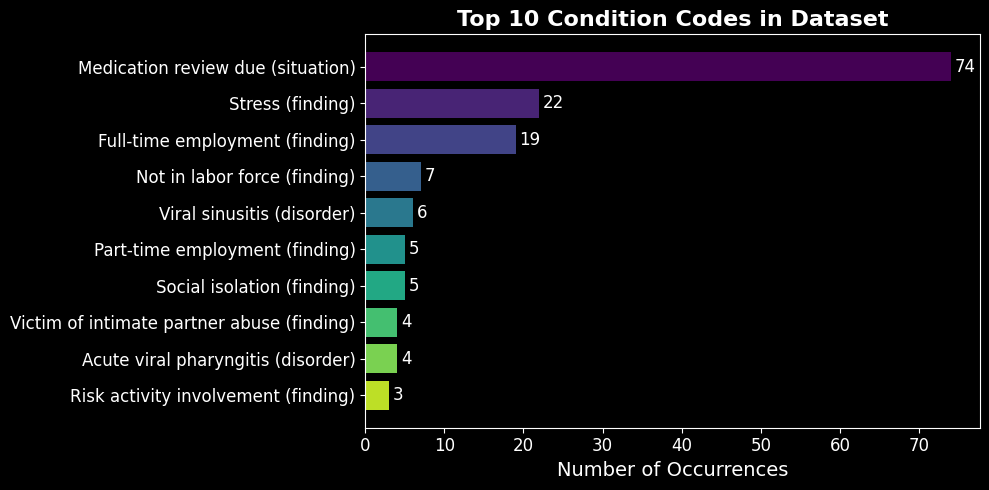

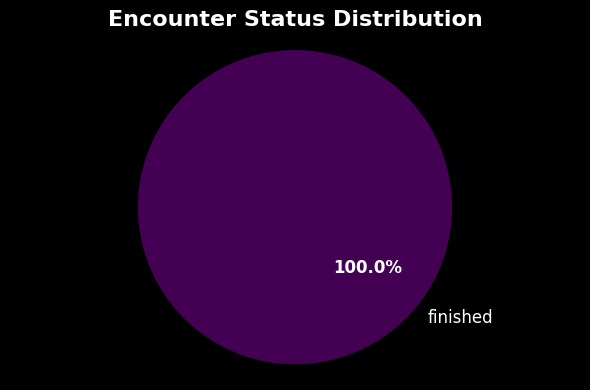

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use("dark_background")

# Plot most common Condition codes
if condition_codes:
    code_counts = Counter(condition_codes).most_common(10)
    codes, counts = zip(*code_counts)
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(codes, counts, color=cm.viridis([i/10 for i in range(len(codes))]))
    ax.set_xlabel("Number of Occurrences", fontsize=14, color='white')
    ax.set_title("Top 10 Condition Codes in Dataset", fontsize=16, color='white', weight='bold')
    ax.invert_yaxis()
    ax.tick_params(colors='white', labelsize=12)
    for spine in ax.spines.values():
        spine.set_color('white')
    for i, v in enumerate(counts):
        ax.text(v + 0.5, i, str(v), color='white', va='center', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot Encounter status distribution
if encounter_types:
    type_counts = Counter(encounter_types).most_common(10)
    types, counts = zip(*type_counts)
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(types, counts, color=cm.viridis([i/10 for i in range(len(types))]))
    ax.set_xlabel("Number of Encounters", fontsize=14, color='white')
    ax.set_title("Top Encounter Types", fontsize=16, color='white', weight='bold')
    ax.invert_yaxis()
    ax.tick_params(colors='white', labelsize=12)
    for spine in ax.spines.values():
        spine.set_color('white')
    for i, v in enumerate(counts):
        ax.text(v + 0.5, i, str(v), color='white', va='center', fontsize=12)
    plt.tight_layout()
    plt.show()